# マルコフ連鎖モンテカルロ法 (MCMC)
前節では解析的に事後分布の計算をした．事後分布を近似的に推論する方法の1つに**マルコフ連鎖モンテカルロ法 (Markov chain Monte Carlo methods; MCMC)** がある．他の近似推論の手法としてはLaplace近似や変分推論（variational inference）などがある．MCMCは他の手法に比して，事後分布の推論だけでなく，確率分布を神経活動で表現する方法を提供するという利点がある．

データを$X$とし，パラメータを$\theta$とする．

$$
\begin{equation}
p(\theta\mid X)=\frac{p(X\mid \theta)p(\theta)}{\int p(X\mid \theta)p(\theta)d\theta}
\end{equation}
$$

分母の積分計算$\int p(X\mid \theta)p(\theta)d\theta$が求まればよい．

### モンテカルロ法

### マルコフ連鎖


## Metropolis-Hastings法


In [149]:
using Base: @kwdef
using PyPlot, LinearAlgebra, Random, Distributions, ForwardDiff, KernelDensity, StatsBase
rc("axes.spines", top=false, right=false)

In [63]:
mixed_gauss = MixtureModel([MvNormal(zeros(2), I), MvNormal(3*ones(2), I)], [0.5, 0.5]) # 分布を混ぜる

MixtureModel{IsoNormal}(K = 2)
components[1] (prior = 0.5000): IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0 0.0; 0.0 1.0]
)

components[2] (prior = 0.5000): IsoNormal(
dim: 2
μ: [3.0, 3.0]
Σ: [1.0 0.0; 0.0 1.0]
)



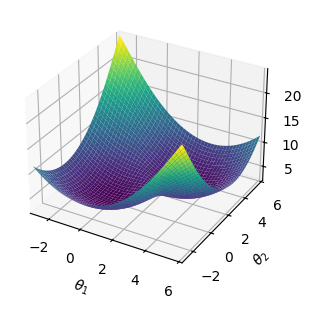

In [132]:
x = -3:0.1:6
pd(x₁, x₂) = logpdf(mixed_gauss, [x₁, x₂])

mixed_gauss_heat = pd.(x, x');

xpos = x * ones(size(x))'

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(projection="3d")
surf = ax.plot_surface(xpos, xpos', -mixed_gauss_heat, cmap="viridis")
ax.set_xlim(-3, 6); ax.set_ylim(-3, 6); 
ax.set_xlabel(L"$\theta_1$"); ax.set_ylabel(L"$\theta_2$"); ax.set_zlabel(L"$-\log p$"); 
tight_layout()

Metropolis-Hastings法における採用・不採用アルゴリズム．

In [65]:
# Metropolis-Hastings method; log_p: unnormalized log-posterior
function gaussian_mh(log_p::Function, θ_init::Vector{Float64}, σ::Float64, num_iter::Int)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:num_iter
        θ_ = rand(MvNormal(θ, σ*I))
        mH = log_p(θ) + logpdf(MvNormal(θ, σ*I), θ_)       # initial Hamiltonian
        mH_ = log_p(θ_) + logpdf(MvNormal(θ_, σ*I), θ)    # final Hamiltonian
        
        if min(1, exp(mH_ - mH)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end;

In [66]:
log_p(θ) = logpdf(mixed_gauss, θ);
grad(θ)= ForwardDiff.gradient(log_p, θ)

grad (generic function with 1 method)

In [67]:
θm, num_accepted = gaussian_mh(log_p, [1.0,0.5], 1.0, 2000)

([1.1351138364908528 1.1351138364908528 … 0.0352364024640921 0.0352364024640921; 1.7660226548269873 1.7660226548269873 … -2.599486844983895 -2.599486844983895], 1214)

In [68]:
size(θm)

(2, 2000)

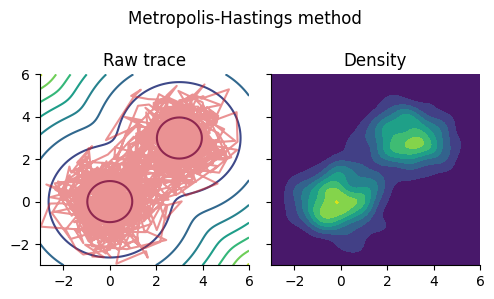

In [69]:
Um = kde((θm[1, :], θm[2, :]));

fig, ax = subplots(1, 2, figsize=(5, 3), sharex="all", sharey="all")
fig.suptitle("Metropolis-Hastings method")
ax[1].set_title("Raw trace")
ax[1].contour(x, x, -mixed_gauss_heat)
ax[1].plot(θm[1, :], θm[2, :], color="tab:red", alpha=0.5)
ax[1].set_xlim(-3,6); ax[1].set_ylim(-3,6)
ax[2].set_title("Density")
ax[2].contourf(Um.x, Um.x, Um.density)
fig.tight_layout()

## ランジュバン・モンテカルロ法 (LMC)
拡散過程

$$
\begin{equation}
{\frac{d\theta}{dt}}=\nabla \log p (\theta)+{\sqrt 2}{d{W}}
\end{equation}
$$

Euler–Maruyama法により，

In [1]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function lmc(log_p::Function, θ_init::Vector{Float64}, ϵ::Float64, num_iter::Int; β=1)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    ρ = sqrt(2*ϵ);
    for m in 1:num_iter
        θ += ϵ * β * grad(θ) + ρ * randn(d)
        samples[:, m] = θ
    end
    return samples
end;

In [147]:
θl = lmc(log_p, [1.0,0.5], 0.1, 5000)

2×5000 Matrix{Float64}:
 0.812361  1.03349   0.625841  0.760982  …  0.807633  0.3819   0.908114
 0.815885  0.822352  0.958634  1.05717      2.04336   2.40659  2.14842

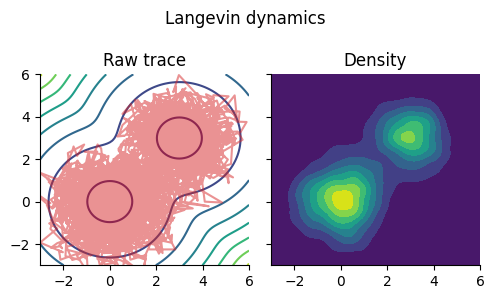

In [148]:
Ul = kde((θl[1, :], θl[2, :]));

fig, ax = subplots(1, 2, figsize=(5, 3), sharex="all", sharey="all")
fig.suptitle("Langevin dynamics")
ax[1].set_title("Raw trace")
ax[1].contour(x, x, -mixed_gauss_heat)
ax[1].plot(θl[1, :], θl[2, :], color="tab:red", alpha=0.5)
ax[1].set_xlim(-3,6); ax[1].set_ylim(-3,6)
ax[2].set_title("Density")
ax[2].contourf(Ul.x, Ul.x, Ul.density)
fig.tight_layout()

## ハミルトニアン・モンテカルロ法 (HMC法)

LMCよりも一般的なMCMCの手法としてHamiltonianモンテカルロ法(Hamiltonian Monte Calro; HMC)あるいはハイブリッド・モンテカルロ法(Hybrid Monte Calro)がある．エネルギーポテンシャルの局面上をHamilton力学に従ってパラメータを運動させることにより高速にサンプリングする手法である．

一般化座標を$\mathbf{q}$, 一般化運動量を$\mathbf{p}$とする．ポテンシャルエネルギーを$U(\mathbf{q})$としたとき，古典力学（解析力学）において保存力のみが作用する場合の**ハミルトニアン (Hamiltonian)** $\mathcal{H}(\mathbf{q}, \mathbf{p})$は

$$
\begin{equation}
\mathcal{H}(\mathbf{q}, \mathbf{p}):=U(\mathbf{q})+\frac{1}{2}\|\mathbf{p}\|^2
\end{equation}
$$

となる．このとき，次の2つの方程式が成り立つ．

$$
\begin{equation}
\frac{d\mathbf{q}}{dt}=\frac{\partial \mathcal{H}}{\partial \mathbf{p}}=\mathbf{p},\quad\frac{d\mathbf{p}}{dt}=-\frac{\partial \mathcal{H}}{\partial \mathbf{q}}=-\frac{\partial U}{\partial \mathbf{q}}
\end{equation}
$$

これを**ハミルトンの運動方程式(hamilton's equations of motion)** あるいは**正準方程式 (canonical equations)** という．



リープフロッグ(leap frog)法により離散化する．

In [74]:
function leapfrog(grad::Function, θ::Vector{Float64}, p::Vector{Float64}, ϵ::Float64, L::Int)
    for l in 1:L
        p += 0.5 * ϵ * grad(θ)
        θ += ϵ * p
        p += 0.5 * ϵ * grad(θ)
    end
    return θ, p
end;

In [75]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function hmc(log_p::Function, θ_init::Vector{Float64}, ϵ::Float64, L::Int, num_iter::Int)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:num_iter
        p = randn(d) # get momentum        
        H = -log_p(θ) + 0.5 * p' * p        # initial Hamiltonian
        θ_, p_ = leapfrog(grad, θ, p, ϵ, L) # update
        H_ = -log_p(θ_) + 0.5 * p_' * p_    # final Hamiltonian
        
        if min(1, exp(H - H_)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end;

In [145]:
θs, _ = hmc(log_p, [1.0,0.5], 0.1, 5, 5000)
Us = kde((θs[1, :], θs[2, :]));

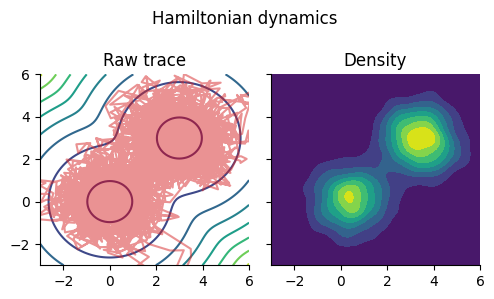

In [146]:
fig, ax = subplots(1, 2, figsize=(5, 3), sharex="all", sharey="all")
fig.suptitle("Hamiltonian dynamics")
ax[1].set_title("Raw trace")
ax[1].contour(x, x, -mixed_gauss_heat)
ax[1].plot(θs[1, :], θs[2, :], color="tab:red", alpha=0.5)
ax[1].set_xlim(-3,6); ax[1].set_ylim(-3,6)
ax[2].set_title("Density")
ax[2].contourf(Us.x, Us.x, Us.density)
fig.tight_layout()

In [152]:
size(θs[1, :])

(5000,)

In [156]:
autocorr_s = autocor(θs[1, :], 1:length(θs[1, :])-1)
autocorr_l = autocor(θl[1, :], 1:length(θl[1, :])-1);

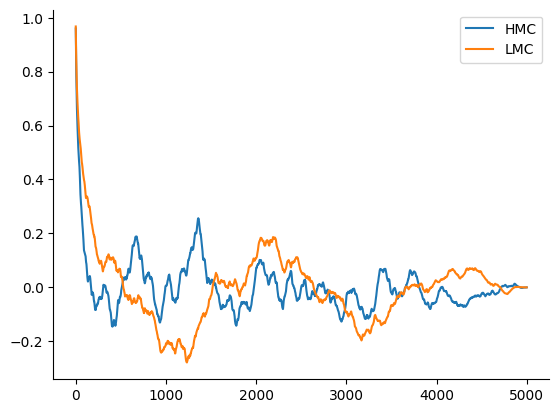

PyObject <matplotlib.legend.Legend object at 0x0000024CAF390920>

In [159]:
plot(autocorr_s, label="HMC")
plot(autocorr_l, label="LMC")
legend()

*ToDo: 自己相関確認する*

## 線形回帰への適応


In [99]:
# Generate Toy datas
n_train, n_test = 50, 100 # sample size
n_iter = 1000
n_burn_in = 500
dims = 4 # dimensions
σy = 0.3

polynomial_expansion(x; degree=3) = stack([x .^ p for p in 0:degree]);

Random.seed!(0);
x = rand(n_train)
y = sin.(2π*x) + σy * randn(n_train);
ϕ = polynomial_expansion(x, degree=dims-1) # design matrix

xtest = range(-0.1, 1.1, length=n_test)
ytest = sin.(2π*xtest)
ϕtest = polynomial_expansion(xtest, degree=dims-1);

In [100]:
log_joint(w, ϕ, y, σy, μ₀, Σ₀) = sum(logpdf.(Normal.(ϕ * w, σy), y)) + logpdf(MvNormal(μ₀, Σ₀), w);

In [101]:
α, β = 5e-3, 5.0

(0.005, 5.0)

In [102]:
w = randn(dims)
μ₀ = zeros(dims)
Σ₀ = 1/α * I;

In [103]:
ulp(w) = log_joint(w, ϕ, y, σy, μ₀, Σ₀)

ulp (generic function with 1 method)

In [104]:
w_init = rand(MvNormal(μ₀, Σ₀), 1)[:, 1]

4-element Vector{Float64}:
 21.63668275657154
  2.3512978351397225
  4.110944423223151
 12.557040811868173

In [105]:
@time samples, num_accepted = hmc(ulp, w_init, 1e-2, 10, n_iter)

  0.190196 seconds (410.46 k allocations: 114.045 MiB, 11.50% gc time, 51.97% compilation time: 22% of which was recompilation)


([-14.457360674868394 19.876051814797368 … 0.6213338006046889 0.6181011430761764; -17.713989992773104 2.584965563826687 … 1.8854618318703003 1.8106327799511202; -10.154202546132097 4.390262620447917 … -11.718951157059747 -11.843396243614198; 1.5014062855010502 12.7074679724204 … 9.230941488139168 9.162024217254054], 998)

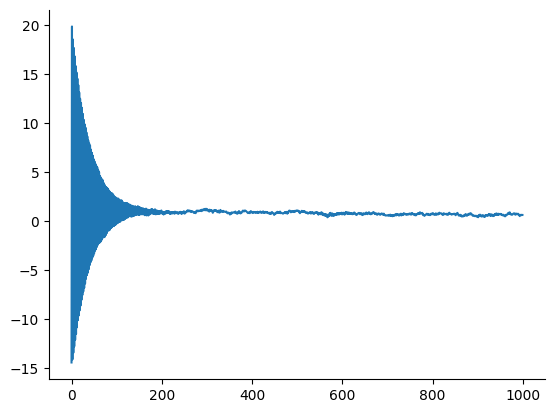

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000024CAAE447A0>

In [106]:
plot(samples[1, :])

In [107]:
yhmc = ϕtest * samples[:, n_burn_in:end];
yhmc_mean = mean(yhmc, dims=2)[:];
yhmc_std = std(yhmc, dims=2)[:];

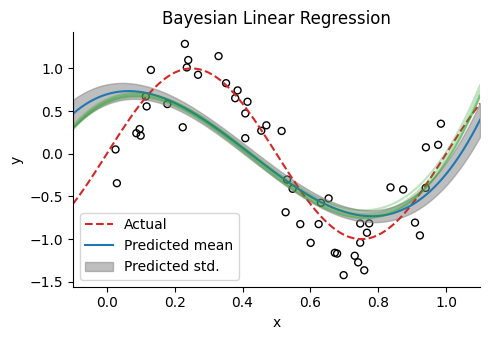

In [108]:
figure(figsize=(5,3.5))
title("Bayesian Linear Regression")
scatter(x, y, facecolor="None", edgecolors="black", s=25) # samples
plot(xtest, ytest, "--", label="Actual", color="tab:red")  # regression line
plot(xtest, yhmc_mean, label="Predicted mean", color="tab:blue")  # regression line
fill_between(xtest, yhmc_mean+yhmc_std, yhmc_mean-yhmc_std, alpha=0.5, color="tab:gray", label="Predicted std.")
for i in 1:5
    plot(xtest, yhmc[:, end-i], alpha=0.3, color="tab:green")
end
xlabel("x"); ylabel("y"); legend()
xlim(-0.1, 1.1); tight_layout()